In [1]:
import torch
import numpy as np
import math
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt

In [2]:
T_ = 100
sigma = 0.1
gamma = 0.1
x_dim = 2
y_dim = 2
mean = torch.zeros(x_dim)
cov = torch.eye(x_dim)
eps = 0.01

In [3]:
def KFilter(theta):
    x0 = torch.tensor([1., 2.])# initialization of X0
    X = torch.zeros(T_, x_dim)
    Y = torch.zeros(T_, y_dim)
    A_theta = torch.diag(torch.tensor(theta))

    for t in range(T_):
        zeta = MultivariateNormal(mean, (sigma**2)*cov)
        eta = MultivariateNormal(mean, (gamma**2)*cov)
        if t == 0:
            X[t,:] = x0@A_theta + zeta.sample()
        else:
            x = X[t-1,:]
            X[t,:] = x@A_theta + zeta.sample()
            
        Y[t,:] = X[t,:] + eta.sample()
        
    return X, Y

In [4]:
# generating data
num_data_set = 2
X = torch.zeros(T_, num_data_set, x_dim)
Y = torch.zeros(T_, num_data_set, y_dim)
for i in range(num_data_set):
  X_data, Y_data = KFilter([.9, .8])
  X[:, i, :], Y[:, i, :] = X_data, Y_data

X, Y = X.mean(dim = -2), Y.mean(dim = -2)

In [5]:
device = torch.device("cpu")

def EnKF_log_likelihood(theta, Y, N_ensem, x0 = torch.tensor([1.,2.])):
    # Compute log_likelihood of theta
    # Y: the observation from time 1 to time T, 2*T matrix, with each column represents the state at time t
    # theta: the variable in log_likelihood
    # N_ensem: number of particles
    # x0: initialization
    
    log_likelihood = torch.tensor(0., device = device)
    T = Y.shape[-2]
    X = x0.expand((N_ensem, x_dim))

    
    for j in range(T):
        # Forcast Step
        X = X * theta
        #X = X @ A_theta
        X = X + MultivariateNormal(mean.expand(N_ensem, x_dim), (sigma**2)*cov).sample() # model error for X: dim = (N_ensem, x_dim)
        X_m = X.mean(dim = -2).unsqueeze(-2) # dim = (1, x_dim)
        X_ct = X - X_m
        
        # Analysis Step: for $A_{\theta}$ is a linear operator
        y_obs_j = Y[j].unsqueeze(-2) # dim = (1, y_dim)
        y_obs_perturb = MultivariateNormal(y_obs_j.expand(N_ensem, y_dim), (gamma**2)*cov).sample()
        
        C_uu = 1/(N_ensem - 1)*X_ct.transpose(-1, -2)@X_ct # dim = (1, x_dim)
        # In this model, setting H = I
        HX = X
        HX_m = X_m
        HC = C_uu
        HCH_T = HC
        HCH_TR_chol = torch.linalg.cholesky(HCH_T + (gamma**2)*cov)
        d = MultivariateNormal(HX_m.squeeze(-2), scale_tril = HCH_TR_chol)
        log_likelihood += d.log_prob(y_obs_j.squeeze(-2))
        
        # Update X
        pre = (y_obs_perturb-HX)@torch.cholesky_inverse(HCH_TR_chol)
        X = X + pre@HC
    
    return X, log_likelihood

In [6]:
def true_log_likelihood(Y, theta, m0 = torch.tensor([1., 2.]), C0 = torch.tensor([[1., 0.],[0., 1.]])):
  # calculate the true log likelihood for theta

  sum_log_likelihood = 0
  J = Y.shape[-2]
  Id = torch.tensor([[1., 0.], [0., 1]])
  m = m0
  C = C0

  for j in range(J):
    # prediction part
    m_hat = theta * m # calculate \hat{m_{j+1}}
    C_hat = theta*C*theta.t() + (gamma**2)*cov

    # Analysis part
    dj = Y[j]-m_hat
    S = C_hat + (gamma**2)*cov
    S_inv = torch.linalg.inv(S)
    K = C_hat@S_inv
    m = m_hat + dj@K.t()
    C = (Id - K)@C_hat

    norm_error = (Y[j]-m_hat)@S_inv@(Y[j]-m_hat).t()
    sum_log_likelihood += 2 * torch.log(torch.tensor(2*math.pi))
    sum_log_likelihood += norm_error
    sum_log_likelihood += torch.log(torch.det(S))

  sum_log_likelihood *= (-1/2)

  return sum_log_likelihood

In [14]:
# gradient ascent (N_ensem = 20)
from torch.distributions.multivariate_normal import MultivariateNormal

alpha = .2
eta = 2e-4 # learning rate
theta = torch.tensor([0., 0.]) # initial value of theta
k = 1
diff = 1
eps = 1e-10
n_iterations = 200
iter1_theta1 = []
iter1_theta2 = []
grad1_theta1 = []
grad1_theta2 = []
log_like1_theta = []
true_log_like1 = []

while k <= n_iterations and diff > eps:
    theta_k = theta.clone().detach().requires_grad_(True)
    X__, L = EnKF_log_likelihood(theta_k, Y, N_ensem = 20)
    log_like1_theta.append(L)
    L.backward()
    grad_log_likelihood = theta_k.grad
    grad1_theta1.append(grad_log_likelihood[0])
    grad1_theta2.append(grad_log_likelihood[1])
    k = k+1
    #theta_new = theta + eta * grad_log_likelihood
    theta_new = theta + eta*(k**(-alpha)) * grad_log_likelihood
    diff = torch.linalg.norm(theta_new - theta)
    true_log_like_ = true_log_likelihood(Y, theta)
    theta = theta_new
    true_log_like1.append(true_log_like_)
    iter1_theta1.append(theta[0])
    iter1_theta2.append(theta[1])

In [15]:
# gradient ascent (N_ensem = 200)
from torch.distributions.multivariate_normal import MultivariateNormal

alpha = .2
eta = 2e-4 # learning rate
theta = torch.tensor([0., 0.]) # initial value of theta
k = 1
diff = 1
eps = 1e-10
n_iterations = 200
iter2_theta1 = []
iter2_theta2 = []
grad2_theta1 = []
grad2_theta2 = []
log_like2_theta = []
true_log_like2 = []

while k <= n_iterations and diff > eps:
    theta_k = theta.clone().detach().requires_grad_(True)
    X__, L = EnKF_log_likelihood(theta_k, Y, N_ensem = 200)
    log_like2_theta.append(L)
    L.backward()
    grad_log_likelihood = theta_k.grad
    grad2_theta1.append(grad_log_likelihood[0])
    grad2_theta2.append(grad_log_likelihood[1])
    k = k+1
    #theta_new = theta + eta * grad_log_likelihood
    theta_new = theta + eta*(k**(-alpha)) * grad_log_likelihood
    diff = torch.linalg.norm(theta_new - theta)
    true_log_like_ = true_log_likelihood(Y, theta)
    theta = theta_new
    true_log_like2.append(true_log_like_)
    iter2_theta1.append(theta[0])
    iter2_theta2.append(theta[1])

In [16]:
# gradient ascent (N_ensem = 2000)
from torch.distributions.multivariate_normal import MultivariateNormal

alpha = .2
eta = 2e-4 # learning rate
theta = torch.tensor([0., 0.]) # initial value of theta
k = 1
diff = 1
eps = 1e-10
n_iterations = 200
iter3_theta1 = []
iter3_theta2 = []
grad3_theta1 = []
grad3_theta2 = []
log_like3_theta = []
true_log_like3 = []

while k <= n_iterations and diff > eps:
    theta_k = theta.clone().detach().requires_grad_(True)
    X__, L = EnKF_log_likelihood(theta_k, Y, N_ensem = 2000)
    log_like3_theta.append(L)
    L.backward()
    grad_log_likelihood = theta_k.grad
    grad3_theta1.append(grad_log_likelihood[0])
    grad3_theta2.append(grad_log_likelihood[1])
    k = k+1
    #theta_new = theta + eta * grad_log_likelihood
    theta_new = theta + eta*(k**(-alpha)) * grad_log_likelihood
    diff = torch.linalg.norm(theta_new - theta)
    true_log_like_ = true_log_likelihood(Y, theta)
    theta = theta_new
    true_log_like3.append(true_log_like_)
    iter3_theta1.append(theta[0])
    iter3_theta2.append(theta[1])

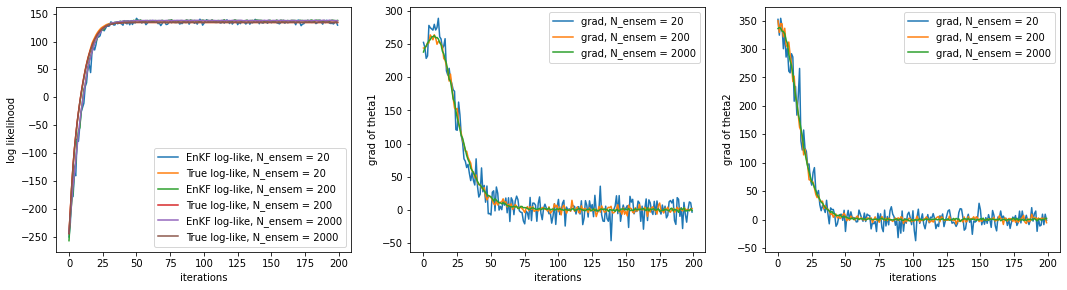

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 4.5))


plt.subplot(1,3,1)
plt.plot(range(len(log_like1_theta)), torch.tensor(log_like1_theta).detach().numpy(), label = 'EnKF log-like, N_ensem = 20')
plt.plot(range(len(true_log_like1)), torch.tensor(true_log_like1).detach().numpy(), label = 'True log-like, N_ensem = 20')
plt.plot(range(len(log_like2_theta)), torch.tensor(log_like2_theta).detach().numpy(), label = 'EnKF log-like, N_ensem = 200')
plt.plot(range(len(true_log_like2)), torch.tensor(true_log_like2).detach().numpy(), label = 'True log-like, N_ensem = 200')
plt.plot(range(len(log_like3_theta)), torch.tensor(log_like3_theta).detach().numpy(), label = 'EnKF log-like, N_ensem = 2000')
plt.plot(range(len(true_log_like3)), torch.tensor(true_log_like3).detach().numpy(), label = 'True log-like, N_ensem = 2000')
plt.ylabel('log likelihood')
plt.xlabel('iterations')
plt.legend()


plt.subplot(1,3,2)
plt.plot(range(len(grad1_theta1)), torch.tensor(grad1_theta1).detach().numpy(), label = 'grad, N_ensem = 20')
plt.plot(range(len(grad2_theta1)), torch.tensor(grad2_theta1).detach().numpy(), label = 'grad, N_ensem = 200')
plt.plot(range(len(grad3_theta1)), torch.tensor(grad3_theta1).detach().numpy(), label = 'grad, N_ensem = 2000')
plt.ylabel('grad of theta1')
plt.xlabel('iterations')
plt.legend()

plt.subplot(1,3,3)
plt.plot(range(len(grad1_theta2)), torch.tensor(grad1_theta2).detach().numpy(), label = 'grad, N_ensem = 20')
plt.plot(range(len(grad2_theta2)), torch.tensor(grad2_theta2).detach().numpy(), label = 'grad, N_ensem = 200')
plt.plot(range(len(grad3_theta2)), torch.tensor(grad3_theta2).detach().numpy(), label = 'grad, N_ensem = 2000')
plt.ylabel('grad of theta2')
plt.xlabel('iterations')
plt.legend()

'''
plt.subplot(2,2,3)


plt.subplot(2,2,4)
'''

plt.show()

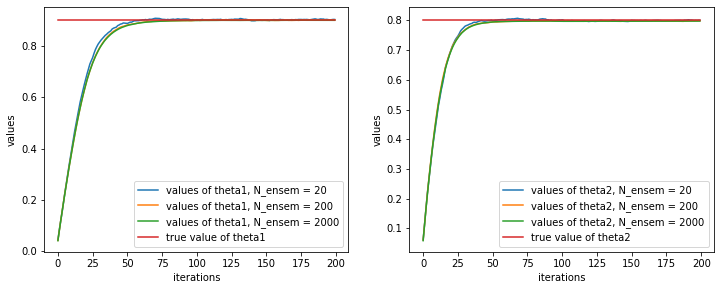

In [ ]:
fig = plt.figure(figsize=(12, 4.5))

plt.subplot(1,2,1)
plt.plot(range(len(iter1_theta1)), torch.tensor(iter1_theta1).clone().numpy(), label = 'values of theta1, N_ensem = 20')
plt.plot(range(len(iter2_theta1)), torch.tensor(iter2_theta1).clone().numpy(), label = 'values of theta1, N_ensem = 200')
plt.plot(range(len(iter3_theta1)), torch.tensor(iter3_theta1).clone().numpy(), label = 'values of theta1, N_ensem = 2000')
plt.plot(range(len(iter1_theta1)), .9*np.ones((len(iter1_theta1),)), label = 'true value of theta1')
plt.xlabel('iterations')
plt.ylabel('values')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(iter1_theta2)), torch.tensor(iter1_theta2).clone().numpy(), label = 'values of theta2, N_ensem = 20')
plt.plot(range(len(iter2_theta2)), torch.tensor(iter2_theta2).clone().numpy(), label = 'values of theta2, N_ensem = 200')
plt.plot(range(len(iter3_theta2)), torch.tensor(iter3_theta2).clone().numpy(), label = 'values of theta2, N_ensem = 2000')
plt.plot(range(len(iter1_theta2)), .8*np.ones((len(iter1_theta2),)), label = 'true value of theta2')
plt.xlabel('iterations')
plt.ylabel('values')
plt.legend()

plt.show()